# hilbert-genome-cooler

#### Overview

We use the Python `numpy-hilbert-curve` (`hilbert`) and `cooler` packages to create a multiscale `mcool` file of Hilbert curve data. 

Each scale of the `mcool` file is derived from integer-keyed categorical data (e.g., chromatin states or DHS components) at each Hilbert curve order, and put into its own `cool` file.

The set of `cool` files — each at its own "resolution" to represent Hilbert curve order — can then be loaded into a final `mcool` file.

#### Notes

1. This does not yet use the custom Hilbert curve aggregation function defined in the Observable notebook. Instead, we are generating random integers as placeholder data.

2. This does not yet look at using HiGlass to render this `mcool` file; customization of the 2D track type will be required for presenting categorical data, similar to what was required for using HiGlass to render chromatin state or DHS component "tornado" multivec tracks. 

In [1]:
%%bash

pip install numpy-hilbert-curve
pip install cooler
pip install matplotlib

In [2]:
import sys
import os
import gzip
import subprocess
import numpy as np
import hilbert
import matplotlib.pyplot as plt
import cooler

In [3]:
data_dir = 'hilbert_genome_cooler_data'
if not os.path.exists(data_dir): 
    os.makedirs(data_dir)

In [4]:
# The following directive activates inline plotting
%matplotlib inline

In [5]:
curve_order = { 'min': 2, 'max': 10 }
assert(curve_order['min'] > 1)
curve_orders = list(range(curve_order['min'], curve_order['max'] + 1))
curve_orders = list(reversed(curve_orders))

Create a pseudo-chromsizes file for the maximum curve order:

In [6]:
chrom_name = 'pseudo'

Specify the bin resolution, ideally as a multiple of the highest curve order:

In [7]:
resolution = 2**curve_order['max'] * len(curve_orders)
resolution

9216

In [8]:
chromsizes_fn = os.path.join(data_dir, 'chromsizes.txt')
with open(chromsizes_fn, 'w') as ofh:
    chrom_size = resolution
    ol = '{}\t{}\n'.format(chrom_name, chrom_size)
    ofh.write(ol)

Create a vector of random chromatin states for each curve order, and write data to BG2 format (chrom1, start1, end1, chrom2, start2, end2, score).

Eventually, chromatin states (or other categorical data) will be derived from applying Observable notebook code that aggregates signal over the whole genome.

The bin size at each curve order is the resolution divided by the order. This determines the ultimate size of a Hilbert curve cell at each coordinate pair. 

Coordinate pairs — BG2 pairs — need to based upon Hilbert curve ordering. We use the `hilbert` package to map locations into an index-able order, so that random access to regions of the pseudo-chromosome can be recovered via HiGlass queries later on.

In [9]:
signal_min = 1
signal_max = 255

In [10]:
def bin_size_fn(order):
    return resolution // 2**order

In [11]:
for co_idx, co_val in enumerate(curve_orders):
    output_signal_fn = os.path.join(data_dir, 'bg2.signal.{}.txt.gz'.format(co_val))
    with gzip.open(output_signal_fn, 'wb') as ofh:
        signal_items = 4**co_val
        v = np.random.randint(signal_min, high=signal_max + 1, size=signal_items)
        # print('{}, {}'.format(co, v))
        locs = hilbert.decode(np.arange(signal_items), 2, co_val)
        # print(locs)
        # print(locs[np.lexsort((locs[:,1], locs[:,0]))])
        reordered_idxs = np.lexsort((locs[:,1], locs[:,0]))
        # print(reordered_idxs)
        # print(locs[reordered_idxs])
        # print('{}, {}'.format(co, v[reordered_idxs]))
        reordered_signal = v[reordered_idxs]
        bin_size = bin_size_fn(co_val)
        for loc_idx, loc_val in enumerate(locs[reordered_idxs]):
            chrom1 = chrom_name
            start1 = loc_val[0] * bin_size
            end1 = (loc_val[0] + 1) * bin_size
            chrom2 = chrom_name
            start2 = loc_val[1] * bin_size
            end2 = (loc_val[1] + 1) * bin_size
            score = reordered_signal[loc_idx]
            ol = '{}\t{:d}\t{:d}\t{}\t{:d}\t{:d}\t{:d}\n'.format(chrom1, int(start1), int(end1), chrom2, int(start2), int(end2), int(score))
            # print(ol)
            ofh.write(ol.encode('utf-8'))

Next, we load the per-curve-order BG2 data into its own `cool` file. We use the `--no-symmetric-upper` option to make a square matrix: 

In [12]:
for co_idx, co_val in enumerate(curve_orders):
    input_signal_fn = os.path.join(data_dir, 'bg2.signal.{}.txt.gz'.format(co_val))
    if not os.path.exists(input_signal_fn):
        raise FileNotFoundError("Missing BG2 pair data")
    output_cool_fn =  os.path.join(data_dir, 'bg2.signal.{}.cool'.format(co_val))
    bin_size = bin_size_fn(co_val)
    cooler_load_cmd = 'cooler load -f bg2 --no-symmetric-upper {}:{:d} {} {}'.format(chromsizes_fn, bin_size, input_signal_fn, output_cool_fn)
    subprocess.run(cooler_load_cmd, shell=True, check=True, stderr=subprocess.DEVNULL)

We inspect one of the `cool` files:

In [23]:
test_cool_co = 7
test_cool_fn = os.path.join(data_dir, 'bg2.signal.{}.cool'.format(test_cool_co))
if not os.path.exists(test_cool_fn):
    raise FileNotFoundError("Missing test Cooler file data")
test_cool_fn

'hilbert_genome_cooler_data/bg2.signal.7.cool'

In [24]:
test_cool = cooler.Cooler(test_cool_fn)
test_cool.info

{'bin-size': 72,
 'bin-type': 'fixed',
 'creation-date': '2022-12-02T11:53:24.886324',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.11',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 128,
 'nchroms': 1,
 'nnz': 16384,
 'storage-mode': 'square',
 'sum': 2098877}

Next, we can visualize the `cool` file:

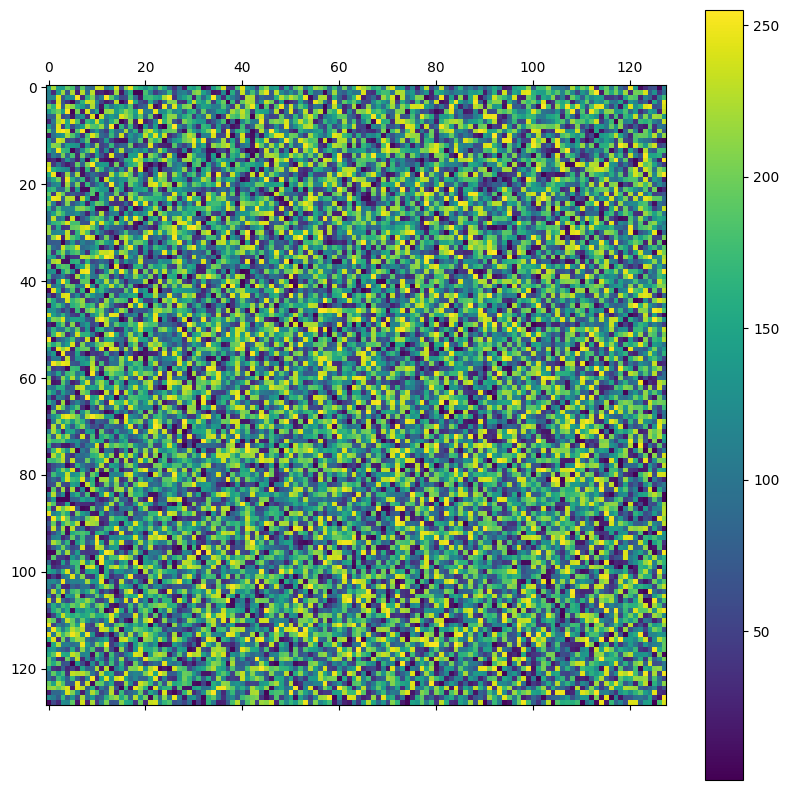

In [25]:
test_cool_arr = test_cool.matrix(balance=False)[:, :]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(test_cool_arr, cmap='viridis')
fig.colorbar(im)

The final step is to compile the per-curve-order `cool` files into one multiscale `mcool` file:

In [26]:
output_mcool_fn = os.path.join(data_dir, 'bg2.signal.mcool')
for co_idx, co_val in enumerate(curve_orders):
    input_bg2_gz_fn =  os.path.join(data_dir, 'bg2.signal.{}.txt.gz'.format(co_val))
    input_bg2_txt_fn =  os.path.join(data_dir, 'bg2.signal.{}.txt'.format(co_val))
    with open(input_bg2_gz_fn, 'rb') as ifh, open(input_bg2_txt_fn, 'w', encoding='utf8') as ofh:
        input_bg2_txt_str = gzip.decompress(ifh.read()).decode('utf-8')
        ofh.write(input_bg2_txt_str)
    bin_size = bin_size_fn(co_val)
    cooler_load_cmd = 'cooler load -f bg2 --no-symmetric-upper {}:{:d} {} {}::resolutions/{:d}'.format(chromsizes_fn, bin_size, input_bg2_txt_fn, output_mcool_fn, bin_size)
    print(cooler_load_cmd)
    subprocess.run(cooler_load_cmd, shell=True, check=True, stderr=subprocess.DEVNULL)

cooler load -f bg2 --no-symmetric-upper hilbert_genome_cooler_data/chromsizes.txt:9 hilbert_genome_cooler_data/bg2.signal.10.txt hilbert_genome_cooler_data/bg2.signal.mcool::resolutions/9
cooler load -f bg2 --no-symmetric-upper hilbert_genome_cooler_data/chromsizes.txt:18 hilbert_genome_cooler_data/bg2.signal.9.txt hilbert_genome_cooler_data/bg2.signal.mcool::resolutions/18
cooler load -f bg2 --no-symmetric-upper hilbert_genome_cooler_data/chromsizes.txt:36 hilbert_genome_cooler_data/bg2.signal.8.txt hilbert_genome_cooler_data/bg2.signal.mcool::resolutions/36
cooler load -f bg2 --no-symmetric-upper hilbert_genome_cooler_data/chromsizes.txt:72 hilbert_genome_cooler_data/bg2.signal.7.txt hilbert_genome_cooler_data/bg2.signal.mcool::resolutions/72
cooler load -f bg2 --no-symmetric-upper hilbert_genome_cooler_data/chromsizes.txt:144 hilbert_genome_cooler_data/bg2.signal.6.txt hilbert_genome_cooler_data/bg2.signal.mcool::resolutions/144
cooler load -f bg2 --no-symmetric-upper hilbert_genome